# Portfolio 
## Music Style Transfer using Convolutional Neural Network
INFO7390: Advances in Data Sciences and Architecture<br/>
Professor Nik Bear Brown


**Pratik Mahajan**<br/>
Information Systems Department<br/>
Northeastern University<br/>
mahajan.pr@husky.neu.edu<br/>

## About:

In this tutorial, we will learn to transfer a music style from one song to another and try to create new music which is combination of both i.e. content of the content music file and style from the styling music. <br/>
We will be using Convolutional Neural Networks for this purpose.

## Prerequisites

1. Short Time Fourier Transform<br/>
    https://en.wikipedia.org/wiki/Short-time_Fourier_transform<br/>
    https://ccrma.stanford.edu/~jos/sasp/Short_Time_Fourier_Transform.html<br/>
    https://musicinformationretrieval.com/stft.html<br/>
2. Neural Artistic Style Transfer<br/>
    https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf<br/>
    https://medium.com/artists-and-machine-intelligence/neural-artistic-style-transfer-a-comprehensive-look-f54d8649c199<br/>
3. Tensorflow<br/>
    https://github.com/PratikMahajan/Data-Science-Reference/tree/master/D01.%20TensorFlow<br/>
    https://github.com/chiphuyen/stanford-tensorflow-tutorials<br/>
    http://cs231n.stanford.edu/<br/>
4. Numpy<br/>
    https://github.com/PratikMahajan/Data-Science-Reference/tree/master/A02.%20NumPy

## Introduction 

In the last decade, Deep Neural Networks(DNNs) have gained a reputation to solve complex problems and emerged as a state of art solution for several (Artificial Intelligence) tasks like image classification, driverless cars, automation, etc 

After the success of Convolution Neural Networks in Image style transfer, we try to apply same technique to perform style transfer on music and look at its advantages and challanges involved. We will be applying convolutional neural networks on spectogram of sound waves and determine weather it is a good decision whether to apply CNN on sound waves. 


By separating and recombining music contents and music style, it is possible to generate new music that is both creative and human-like. In other words, we can still use our favorite data-driven algorithms but twist the constraints or optimizations in general by applying them seprately to different aspects (i.e., content and style) of music

Here we will be doing the music style transfer in a 3 step process:

1. We convert the raw audio signal into its spectogram using the Short Time Fourier Transform. A spectogram is a 2D representation of a 1D signal, thus we can treat it as an image. It is equivalent to 1xT image with F number of channels

2. As we cannot use VGG-19 as 3x3 convolutions for out 1D problem, thus we have to use 1D convolutions. Thus we are training network with random weights. We are using only one layer of 4096 filters. 

3. In the last step, we reconstruct music file from the resultant spectogram. We do this using Griffin-Lim algorithm.

## Running Dependencies

To run this program, we need to install the following libraries/dependencies:
1. Python 2.7
2. Numpy
3. Tensorflow
4. Librosa
5. Matplotlib

## Code

Lets start by importing all the required dependencies for this project.

In [1]:
import tensorflow as tf
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import librosa

Storing path for Content and Style Music in constant variables. 

In [2]:
CONTENT_FILENAME = "input/content.mp3"
STYLE_FILENAME = "input/style.mp3"

The style and the content file can be played in the jupyter notebook below. 

In [3]:
display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))

We are done with the initial part of loading the audio file into the python notebook. <br/>
Our next step will be converting the 1D music files into 2D spectograms. <br/>
To do this, we are using a python library called `librosa`.<br/>
`librosa` is a library for audio and music processing in python

The function below converts the music file into its spectogram

In [4]:
N_FFT = 2048
def read_audio_spectum(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S) #Phase of frequency
    
    S = np.log1p(np.abs(S[:,:430]))  #Magnitude of frequency
    return S, fs

By calling the above function we store the spectogram into the two variables below. 

In [5]:
a_content, fs = read_audio_spectum(CONTENT_FILENAME)
a_style, fs = read_audio_spectum(STYLE_FILENAME)

As we need to transfer style from the style music file to content music file. We need to make sure that both the files have same length. Thus here we are cropping the style file to the length of content file. 

In [6]:
N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]
a_style = a_style[:N_CHANNELS, :N_SAMPLES]

Below we can see the spectograms for the two files, i.e. style and content file. 

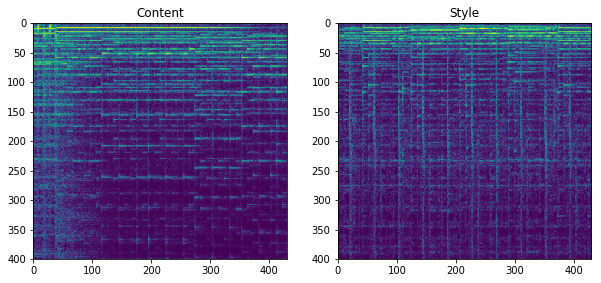

In [7]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.show()

We will be using these two spectograms to transfer styles using Convolutional Neural Networks. 

The method that we are using is similar to the method we use for transferring style between two image files. We interpret the two spectorgrams as image files and carry out image style transfer 

In [8]:
N_FILTERS = 4096

a_content_tf = np.ascontiguousarray(a_content.T[None,None,:,:])
a_style_tf = np.ascontiguousarray(a_style.T[None,None,:,:])

# filter shape is "[filter_height, filter_width, in_channels, out_channels]"
std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * 11))
kernel = np.random.randn(1, 11, N_CHANNELS, N_FILTERS)*std
   

In [9]:
g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    # data shape is "[batch, in_height, in_width, in_channels]",
    x = tf.placeholder('float32', [1,1,N_SAMPLES,N_CHANNELS], name="x") #inputting data to graph 

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    # convolutional neural network 
    conv = tf.nn.conv2d(
        x, #input
        kernel_tf, #filter
        strides=[1, 1, 1, 1],
        padding="VALID", # without padding 
        name="conv")
    #negative to 0- relu
    net = tf.nn.relu(conv)

    content_features = net.eval(feed_dict={x: a_content_tf})
    style_features = net.eval(feed_dict={x: a_style_tf})
    
    features = np.reshape(style_features, (-1, N_FILTERS))
    style_gram = np.matmul(features.T, features) / N_SAMPLES

Above we are training the network with random weights, we will use this to transfer style from style music file to content music file. <br/>
Below we are doing the main music style transfer. <br/>
The main part in this algorithm is the backpropogation. We use the backpropogation in CNN to reduce the loss. 

In [14]:
from sys import stderr

ALPHA= 1e-2
# learning_rate= 1e-3
# iterations = 100

result = None
with tf.Graph().as_default():

    # Build graph with variable input
#     x = tf.Variable(np.zeros([1,1,N_SAMPLES,N_CHANNELS], dtype=np.float32), name="x")
    x = tf.Variable(np.random.randn(1,1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x, #input
        kernel_tf, #filter
        strides=[1, 1, 1, 1],
        padding="VALID", # without padding 
        name="convol")
    
    
    net = tf.nn.relu(conv)

#     net = tf.nn.sigmoid(conv)
    
    content_loss = ALPHA * 2 * tf.nn.l2_loss(
            net - content_features)

    style_loss = 0

    _, height, width, number = map(lambda i: i.value, net.get_shape())

    size = height * width * number
    feats = tf.reshape(net, (-1, number))
    gram = tf.matmul(tf.transpose(feats), feats)  / N_SAMPLES
    style_loss = 2 * tf.nn.l2_loss(gram - style_gram)

     # Calculating Overall loss
    loss = content_loss + style_loss

    opt = tf.contrib.opt.ScipyOptimizerInterface(
          loss, method='L-BFGS-B', options={'maxiter': 100})
    
    
    # Optimization
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
       
        print('Started optimization.')
        opt.minimize(sess)
    
        print 'Final loss:', loss.eval()
        result = x.eval()

Started optimization.
INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  Objective function value: 896.524719
  Number of iterations: 100
  Number of functions evaluations: 110
Final loss: 896.5247


We can increase of reduce the number of iterations above and we can observe the slight difference between the different outputs. Here we are running the algorithm for 100 iterations only. But we can increase this as per our needs. 

Below we will be performing the 3rd step of our music style transfer process. <br/>
We will be using Griffin-Lim algorithm to do this.<br/>
In this we reverse the operation that we performed in the 1st step of our music style transfer.<br/>
Here we convert the spectogram into its music equivalent. <br/>
This converted file will be our required output. And will the complete performing the music style transfer.

In [11]:
a = np.zeros_like(a_content)
a[:N_CHANNELS,:] = np.exp(result[0,0].T) - 1

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, N_FFT))

OUTPUT_FILENAME = 'output/out.wav'
librosa.output.write_wav(OUTPUT_FILENAME, x, fs)

### Result

Lets listen to our result file. i.e. the output for our music style transfer. 

In [12]:
print OUTPUT_FILENAME
display(Audio(OUTPUT_FILENAME))

output/out.wav


Below we can visualize the three files. i.e. Content, Style and the Result.

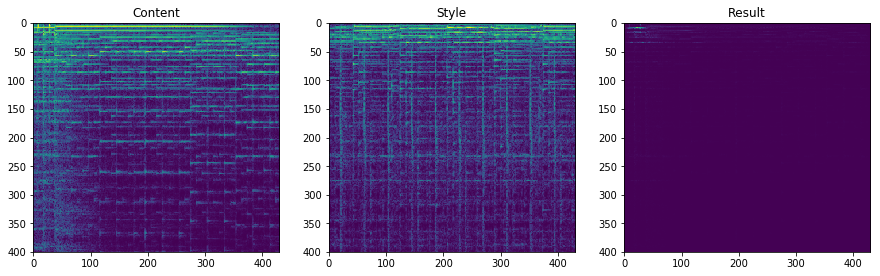

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1,3,2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.subplot(1,3,3)
plt.title('Result')
plt.imshow(a[:400,:])
plt.show()

### Conclusion

The result obtained out of music style transfer has features of both content as well as style audio. But, the different instruments are fused in the output, as a result, it is difficult to identify different instruments from the two different songs. As far as music style transfer is concerned, we were successful in transferring style from one song to another. The output sometimes generates melodious music and sometimes not. The second case happens typically when there is ensamble of multiple instruments in the song. This makes it seem like random instruments are playing from both the songs. But, when we use a single instrument song to transfer styles, we observe that the output is melodious to listen to and also there is good combination of style as well as content in the result.

## References

[1] Leon A. Gatys, Alexander S. Ecker, Matthias Bethge,"A Neural Algorithm of Artistic Style" <br/>
[2] Shuqi Dai, Zheng Zhang, Gus G. Xia, "Music Style Transfer: A Position Paper"<br/>
[3] L. Wyse, "Audio Spectrogram Representations for Processing with Convolutional Neural Networks," vol. 1, no. 1, pp. 37–41, 2017.<br/>
[4] "What’s wrong with CNNs and spectrograms for audio processing?" https://towardsdatascience.com/whats-wrong-with-spectrograms-and-cnns-for-audio-processing-311377d7ccd<br/>
[5] https://github.com/vadim-v-lebedev/audio_style_tranfer <br/>
[6] https://github.com/Lasagne/Recipes/blob/master/examples/styletransfer/Art%20Style%20Transfer.ipynb <br/>
[7] Extreme Style Machines: Using Random Neural Networks to Generate Textures https://nucl.ai/blog/extreme-style-machines/ <br/>
[8] Ivan Ustyuzhaninov, Wieland Brendel, Leon A. Gatys, Matthias Bethge, "Texture Synthesis Using Shallow Convolutional Networks with Random Filters"<br/>
[9] Kun He, Yan Wang, John Hopcroft, "A Powerful Generative Model Using Random Weights for the Deep Image Representation"<br/>
[10] Shaun Barry, Youngmoo Kim, "“Style” Transfer for Musical Audio Using Multiple Time-Frequency Representations "
[11] Dmitry Ulyanov and Vadim Lebedev, "Audio texture synthesis and style transfer"
[12] D. Griffin, jae Lim, "Signal estimation from modified short-time Fourier transform"

## Licensing

The code is licensed under `The MIT License`<br/>
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

The writing is licensed under `Creative Commons Attribution 3.0 License`<br/>
You are free to:<br/>
Share — copy and redistribute the material in any medium or format<br/>
Adapt — remix, transform, and build upon the material<br/>
for any purpose, even commercially.<br/>
This license is acceptable for Free Cultural Works.<br/>
The licensor cannot revoke these freedoms as long as you follow the license terms.<br/>

Under the following terms:<br/>
Attribution — You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.<br/>
No additional restrictions — You may not apply legal terms or technological measures that legally restrict others from doing anything the license permits.<br/>
